# CaStLe Tutorial: Analyzing Sulfate Aerosol Concentration at 50 hPa
This tutorial demonstrates the use of the CaStLe (Causal Space-Time Stencil Learning) algorithm to analyze sulfate aerosol concentration data at 50 hPa. The dataset used in this tutorial is from the Held-Suarez-Williamson-Volcanic (HSW-V) climate model, which simulates the 1991 Mount Pinatubo eruption. The goal is to discover causal structures in the sulfate aerosol concentration data using the CaStLe algorithm.

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

## Loading, Preprocessing, and Visualizing the Data

First, we load the necessary libraries and the dataset. The dataset contains sulfate aerosol concentration data at 50 hPa.

In [2]:
file_path = "../data/sulfate_50hPa.nc"
ds = xr.open_dataset(file_path)

This dataset is from output of one run of the Held-Suarez-Williamson-Volcanic (HSW-V) climate model [1,2]. The run simulates the 1991 Mount Pinatubo eruption over the Philippines.

HSW-V is an atmosphere-only model built in the Department of Energy's Energy Exascale Earth System Model version 2 (E3SMv2). HSW-V does not set out to replicate the historical Mt. Pinatubo eruption or any other, but uses the Mt. Pinatubo's eruption characteristics "to produce a plausible realization of a volcanic event, simulated with a minimal forcing set." The model was developed specifically to facilitate basic research of attribution methodologies by providing realistic source-to-impact pathways of eruption quantities.

[1] Hollowed, J. P., Jablonowski, C., Brown, H. Y., Hillman, B. R., Bull, D. L., and Hart, J. L.: HSW-V v1.0: localized injections of interactive volcanic aerosols and their climate impacts in a simple general circulation model, Geosci. Model Dev., 17, 5913–5938, https://doi.org/10.5194/gmd-17-5913-2024, 2024.

[2] Tom Ehrmann, Benjamin Wagman, Diana Bull, Hunter York Brown, Benjamin Hillman, Kara Peterson, Laura Swiler, Jerry Watkins, and Joseph Hart. 2024. Identifying Northern Hemisphere Temperature Responses to the Mt. Pinatubo Eruption through Limited Variability Ensembles. Submitted to Climate Dynamics 17, 13 (Sept. 2024), 5087-5121. https://doi.org/10.5194/cd-17-5087-2024.

Next, we adjust the longitude coordinates to range from -180 to 180 degrees and sort the dataset by longitude. This makes analyzing and plotting around Mount Pinatubo easier.

In [3]:
# Remake longitude coords to be -180 to 180 instead of 0 to 360
ds.coords["lon"] = (ds.coords["lon"] + 180) % 360 - 180
ds = ds.sortby(ds.lon)

ds

<xarray.Dataset> Size: 315MB
Dimensions:  (lat: 91, time: 4801, lon: 180)
Coordinates:
  * lat      (lat) float64 728B -90.0 -88.0 -86.0 -84.0 ... 84.0 86.0 88.0 90.0
    lev      float64 8B ...
  * time     (time) datetime64[ns] 38kB 1991-03-16T18:00:00 ... 1994-06-28T18...
  * lon      (lon) float64 1kB -180.0 -178.0 -176.0 -174.0 ... 174.0 176.0 178.0
Data variables:
    SULFATE  (time, lat, lon) float32 315MB ...

### Visualizing the data to get a bearing on the dataset
Here, we examine a few snapshots of the dataset to get an idea of the general behavior of sulfate aerosols around the globe and what to expect from our results.

In [4]:
# Average the data over all time steps
sulfate_50hPa_mean = ds.mean(dim="time")

# Convert the start and end dates to pandas.Timestamp objects
start_date = pd.Timestamp(ds.time.values[0])
end_date = pd.Timestamp(ds.time.values[-1])

# Format the dates using strftime
start_date_formatted = start_date.strftime("%b %d %Y")
end_date_formatted = end_date.strftime("%b %d %Y")

#### A mean over all time steps in the dataset

Text(0.5, 1.0, 'Mean Stratospheric Aerosol Injection Plume Sulfate at 50 hPa\nMar 16 1991 - Jun 28 1994')

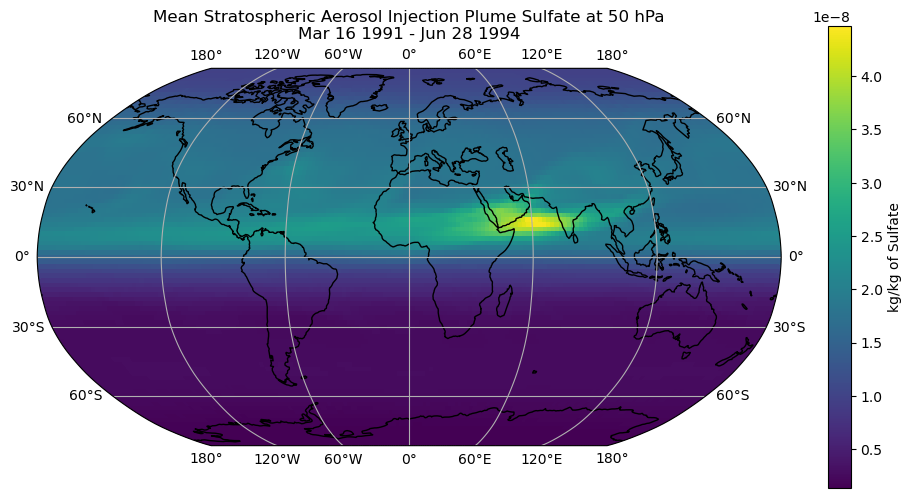

In [5]:
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson())

sulfate_50hPa_mean.SULFATE.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="viridis", cbar_kwargs={"label": f"{ds['SULFATE'].units} of Sulfate"})

ax.coastlines()
ax.gridlines(draw_labels=True)

species_name = ds["SULFATE"].long_name.title()
plt.title(f"Mean {species_name} at 50 hPa\n{start_date_formatted} - {end_date_formatted}")

#### A specific day

Text(0.5, 1.0, 'Stratospheric Aerosol Injection Plume Sulfate at 50 hPa on Jul 07 1991')

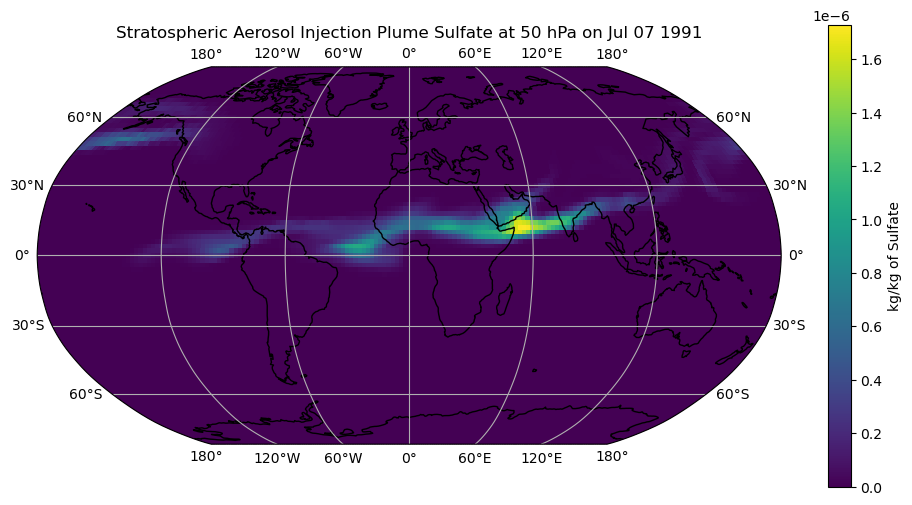

In [6]:
# Select a specific time step (e.g., the first time step)
time_step_index = 450
sulfate_50hPa_specific_time = ds.isel(time=time_step_index)

# Convert the specific time step to a pandas.Timestamp object
specific_time = pd.Timestamp(ds.time.values[time_step_index])

# Format the specific time using strftime
specific_time_formatted = specific_time.strftime("%b %d %Y")

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson())

sulfate_50hPa_specific_time.SULFATE.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="viridis", cbar_kwargs={"label": f"{ds['SULFATE'].units} of Sulfate"})

ax.coastlines()
ax.gridlines(draw_labels=True)

species_name = ds["SULFATE"].long_name.title()
plt.title(f"{species_name} at 50 hPa on {specific_time_formatted}")

#### A mean over a specified interval.
This is the interval under study later in the notebook (time steps 366-450, or roughly the first three weeks after eruption).

Text(0.5, 1.0, 'Mean Stratospheric Aerosol Injection Plume Sulfate at 50 hPa\nJun 16 1991 - Jul 07 1991')

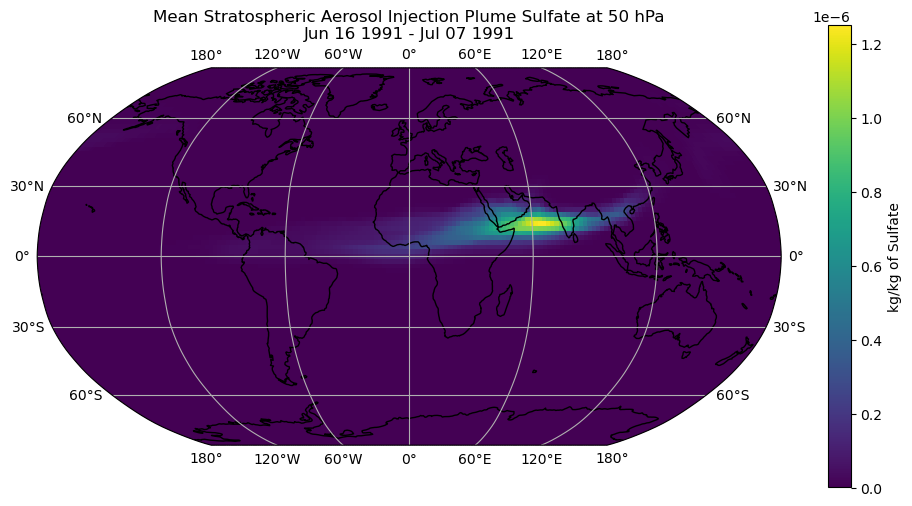

In [7]:
start_time_index = 366
end_time_index = 450
sulfate_50hPa_selected_mean = ds.isel(time=slice(start_time_index, end_time_index)).mean(dim="time")

start_date_selected = pd.Timestamp(ds.time.values[start_time_index])
end_date_selected = pd.Timestamp(ds.time.values[end_time_index])

start_date_selected_formatted = start_date_selected.strftime("%b %d %Y")
end_date_selected_formatted = end_date_selected.strftime("%b %d %Y")

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson())

sulfate_50hPa_selected_mean.SULFATE.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="viridis", cbar_kwargs={"label": f"{ds['SULFATE'].units} of Sulfate"})

ax.coastlines()
ax.gridlines(draw_labels=True)

species_name = ds["SULFATE"].long_name.title()
plt.title(f"Mean {species_name} at 50 hPa\n{start_date_selected_formatted} - {end_date_selected_formatted}")

### Extract Latitudes of Interest
Here, we extract the latitudes between -15 and 45 degrees and longitudes -180 to 180. These are 60 degrees latitude and 360 degrees longitude roughly centered on Pinatubo. Using round numbers that have many common factors, such as 60 and 360, is helpful for making good looking plots below.

In [8]:
import clif

In [9]:
lat_min = -15
lat_max = 45
lon_min = -180
lon_max = 180
lat_lon_clipper = clif.preprocessing.ClipTransform(dims=["lat", "lon"], bounds=[(lat_min, lat_max + 1), (lon_min, lon_max + 1)])

In [10]:
sulfate_da = lat_lon_clipper.fit_transform(ds["SULFATE"])
sulfate_da

<xarray.DataArray 'SULFATE' (time: 4801, lat: 30, lon: 180)> Size: 104MB
array([[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
...
        [2.1219759e-09, 2.1175806e-09, 2.0995641e-09, ...,
         2.0817250e-09, 2.1079010e-09, 2.1237290e-09],
        [2.1345097e-09, 2.1449376e-09, 2.1542430e-09, ...,
         2.0748969e-09, 2.0964623e-09, 2.1222848e-09],
        [2.1309066e-09, 2.1508406e-09, 2.1748907e-09, ...,
         2.0755397e-09, 2.0842590e-09, 2.1106576e-09]],

       [[2.4983712e-10, 2.5247002e-10, 2.6001198e-10, ...,
         2.5063029e-10, 2.4858521e-10, 2.4794300e-10],
        [2.5783187e-10, 2.6381092e-10, 2.7400884e-10, ...,
         2.3898364e-10, 2.4366328e-10, 2.5203017e-10],
        [2.5898253e-10, 2.6050367e-10, 2.6070296e-10, ...,
         2.4872826e-10, 2.5239980e-10, 2.5700614e-10],
        ...,
        [2.1153725e-09, 2.1254873e-09, 2.1241640e-09, ...,
         2.0453519e-09, 2.0682420e-09, 2.1017044e-09],
        [2.1101578e-09, 2.1244213e-09, 2.1427766e-09, ...,
         2.0679021e-09, 2.0747428e-09, 2.0953452e-09],
        [2.0997657e-09, 2.1120805e-09, 2.1407218e-09, ...,
         2.1019215e-09, 2.0938402e-09, 2.0915636e-09]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 240B -14.0 -12.0 -10.0 -8.0 ... 38.0 40.0 42.0 44.0
    lev      float64 8B 53.31
  * time     (time) datetime64[ns] 38kB 1991-03-16T18:00:00 ... 1994-06-28T18...
  * lon      (lon) float64 1kB -180.0 -178.0 -176.0 -174.0 ... 174.0 176.0 178.0
Attributes:
    mdims:          1
    units:          kg/kg
    mixing_ratio:   dry
    long_name:      Stratospheric aerosol injection plume sulfate
    cell_methods:   time: mean
    cell_measures:  area: area

## Applying the CaStLe Algorithm

In [24]:
import matplotlib.patches as mpatches
import numpy as np
import os
import sys
from tigramite.independence_tests.parcorr import ParCorr
from tigramite import plotting as tp

sys.path.append(os.path.abspath("../src/"))
import stencil_plotting
import stencil_functions as sf

Define the partial correlation conditional independence test that we will supply the CaStLe algorithm with. This test is used by the PIP causal discovery algorithm within the CaStLe meta-algorithm.

In [25]:
parcorr = ParCorr(significance="analytic")

Define the analysis region and set heatmap variables.

In [26]:
start_index = 366  # Its best to start a little after the eruption day (361) to make sure the signal has started propagating.
stop_index = 450
max_stop_index = stop_index

spatial_TS_total = np.mean(sulfate_da, axis=(1, 2))[start_index:max_stop_index].values
vmin = spatial_TS_total.min()
vmax = spatial_TS_total.max()

sulfate_arr = sulfate_da.values[start_index:stop_index, :, :]
sulfate_arr = np.transpose(sulfate_arr, (1, 2, 0))

lon_bound = (lon_min, lon_max)
lat_bound = (lat_min, lat_max)
lats = sulfate_da["lat"]
lons = sulfate_da["lon"]
lons, lats = np.meshgrid(lons, lats)

### Fit CaStLe

The CaStLe algorithm leverages various causal discovery algorithms for its parent-identification phase (PIP). The provided code below demonstrates how to use different algorithms, including PC, PC-stable, PCMCI, FullCI, and DYNOTEARS, within the CaStLe framework. CaStLe should be implementable by adapting nearly any timeseries causal discovery algorithm for its PIP. Those below are the currently implemented PIPs. Each of these algorithms has its own strengths and characteristics:

- **PC (Peter-Clark)**: A constraint-based algorithm that identifies causal relationships by testing conditional independencies. It is known for its efficiency and simplicity.
- **PC-stable**: A variant of the PC algorithm that ensures the order of conditional independence tests does not affect the resulting graph, providing more stable results.
- **PCMCI (Peter-Clark Momentary Conditional Independence)**: An extension of the PC algorithm designed for time series data, which accounts for temporal dependencies and provides more accurate causal discovery in dynamic systems.
- **FullCI (Full Conditional Independence)**: An algorithm that performs exhaustive conditional independence tests, providing a comprehensive analysis of causal relationships but at a higher computational cost.
- **DYNOTEARS (Dynamic NO-TEARS)**: A score-optimization-based algorithm that extends the NO-TEARS framework to dynamic systems. It uses gradient-based optimization to discover causal relationships in time series data with non-linear dependencies.

Below, the `CaStLe_PC` function is used to run the CaStLe algorithm with the PC algorithm for parent identification. The commented-out lines show how to use the other algorithms (PC-stable, PCMCI, FullCI, and DYNOTEARS) within the CaStLe framework. By adjusting the parameters and uncommenting the desired algorithm, users can explore different causal discovery methods and their impact on the resulting causal structures.


In [27]:
"""Set the significance level for the PC algorithm used in the CaStLe framework.
This parameter controls the threshold for accepting or rejecting conditional independencies.
A lower value makes the test more stringent, reducing the chance of false positives."""
pc_alpha = 0.01
"""Set the dependence threshold for the final graph output of the CaStLe algorithm.
This parameter determines the minimum absolute value of the dependence coefficient required to include an edge in the final graph.
A value of 0.0 means that all detected dependencies, regardless of their strength, will be included in the final graph."""
castle_corr_threshold = 0.0

graph, v_matrix = sf.CaStLe_PC(data=sulfate_arr, cond_ind_test=parcorr, pc_alpha=pc_alpha, dependence_threshold=castle_corr_threshold)
# graph, v_matrix = sf.CaStLe_PCstable(data=sulfate_arr, cond_ind_test=parcorr, pc_alpha=pc_alpha, dependence_threshold=castle_corr_threshold)
# graph, v_matrix = sf.CaStLe_FullCI(data=sulfate_arr, cond_ind_test=parcorr, alpha_level=pc_alpha, dependence_threshold=castle_corr_threshold)
# graph, v_matrix = sf.CaStLe_PCMCI(data=sulfate_arr, cond_ind_test=parcorr, pc_alpha=pc_alpha, dependence_threshold=castle_corr_threshold)
# graph, v_matrix = sf.CaStLe_DYNOTEARS(data=sulfate_arr, dependence_threshold=castle_corr_threshold)

### Analysis of Causal Stencil Graphs

We've applied CaStLe to the entire region of interest, so we'll get one stencil output that represents the identified local dynamics that CaStLe believes generalizes the entire space. This is generally a bad idea or simply uninformative because there are in fact many different dynamics throughout different regions of the globe.

Here, we visualize the results we computed above.

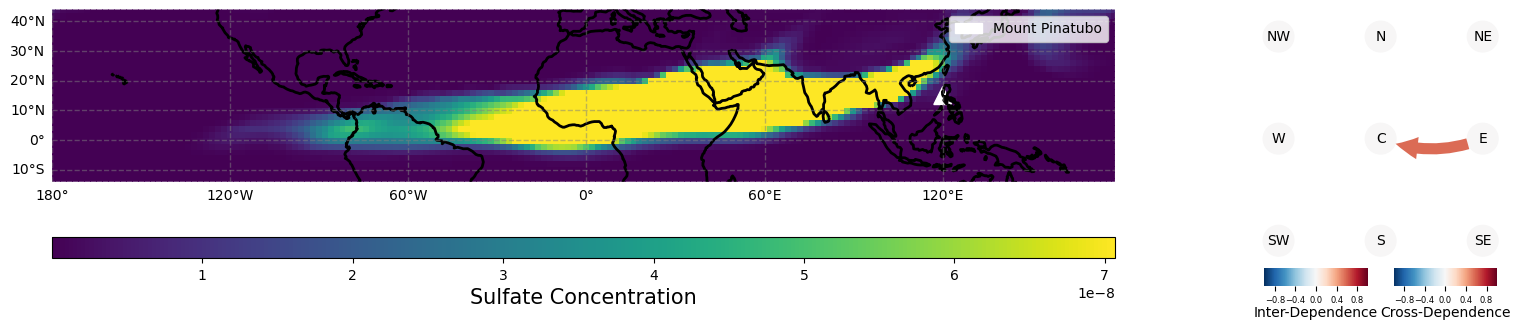

In [28]:
fig = plt.figure(figsize=(18, 9))
gs = fig.add_gridspec(1, 2, width_ratios=[4, 1], wspace=0.1)

# Heatmap plot
ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
heatmap_data = np.mean(sulfate_arr, axis=2)
extent = [lons.min(), lons.max(), lats.min(), lats.max()]
ax.set_extent(extent, crs=ccrs.PlateCarree())
hm = ax.pcolormesh(lons, lats, heatmap_data, vmin=vmin, vmax=vmax, cmap="viridis", snap=False, alpha=1, rasterized=False)  # , edgecolor='k')
ax.coastlines(linewidth=2, color="black")
for spine in ax.spines.values():
    spine.set_visible(False)

# Add colorbar for the heatmap
cbar = fig.colorbar(hm, ax=ax, orientation="horizontal", pad=0.08, aspect=50)
cbar.set_label("Sulfate Concentration", fontsize=15)

# Plot triangle over pinatubo
pinatubo_coords = (15, 120)
offset = 3
tri_vertices = [
    (pinatubo_coords[1], pinatubo_coords[0] + offset),
    (pinatubo_coords[1] - offset, pinatubo_coords[0] - offset),
    (pinatubo_coords[1] + offset, pinatubo_coords[0] - offset),
]
tri_color = "white"
triangle = plt.Polygon(tri_vertices, color=tri_color, fill=True)
ax.add_patch(triangle)

# Add legend for the triangle
triangle_patch = mpatches.Patch(color="white", label="Mount Pinatubo")
ax.legend(handles=[triangle_patch], loc="upper right")

# Add gridlines and labels
gl = ax.gridlines(draw_labels=True, linewidth=1, color="gray", alpha=0.5, linestyle="--")
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {"size": 10, "color": "black"}
gl.ylabel_style = {"size": 10, "color": "black"}

# Stencil plot
ax1 = fig.add_subplot(gs[1], projection=ccrs.PlateCarree())
stencil_plotting.plot_stencil(fig=fig, ax=ax1, stencil_graph=graph, stencil_val_matrix=v_matrix, show_colorbar=True, label_colorbars=True)

# Manually adjust the positions of the axes to align the tops and make the second plot larger
pos1 = ax.get_position()
pos2 = ax1.get_position()

# Adjust the height and width of the second plot
new_height = pos1.height * 1.5  # Increase height by 20%
new_width = pos2.width * 1.5  # Increase width by 20%

# Align the top of ax1 with ax and adjust the size
ax1.set_position([pos2.x0, pos1.y0 - (new_height - pos1.height), new_width, new_height])

While that stencil describes dynamics in the general direction of the volcano's aerosol plume, there are likely more interesting dynamics to discover.

### Computing and Plotting Causal Stencil Graphs for Subregions
We divide the region into smaller subregions and compute the causal stencil graphs for each subregion. This allows us to analyze the causal relationships in different parts of the globe.

In [29]:
lat_bounds, lon_bounds = stencil_plotting.compute_bounds(region_size=20, lat_min=-15, lat_max=45, lon_min=-180, lon_max=180)
print(lat_bounds, len(lat_bounds))
print(lon_bounds, len(lon_bounds))

[(25, 45), (5, 25), (-15, 5)] 3
[(-180, -160), (-160, -140), (-140, -120), (-120, -100), (-100, -80), (-80, -60), (-60, -40), (-40, -20), (-20, 0), (0, 20), (20, 40), (40, 60), (60, 80), (80, 100), (100, 120), (120, 140), (140, 160), (160, 180)] 18


In [30]:
from IPython.display import clear_output

In [31]:
# Parameters
pinatubo_coords = (15, 120)
pc_alpha = 0.01
castle_corr_threshold = 0.0

# Calculate spatial mean and value range
lat_lon_clipper = clif.preprocessing.ClipTransform(dims=["lat", "lon"], bounds=[(lat_min, lat_max), (lon_min, lon_max)])
space_clipped_data = lat_lon_clipper.fit_transform(ds["SULFATE"])
spatial_ts_mean = np.mean(space_clipped_data, axis=(1, 2))[start_index:stop_index].values
vmin, vmax = spatial_ts_mean.min(), spatial_ts_mean.max()

The following will demonstrate how to create a series of subplots that visualize the causal relationships in sulfate aerosol concentration data. We will loop through specified latitude and longitude bounds, clip the data accordingly, and compute the causal graph and value matrix for each region. Finally, we will plot the heatmap and stencil for each region.

Computing on Latitudes: (-15, 5)
Computing on Longitudes: (160, 180)


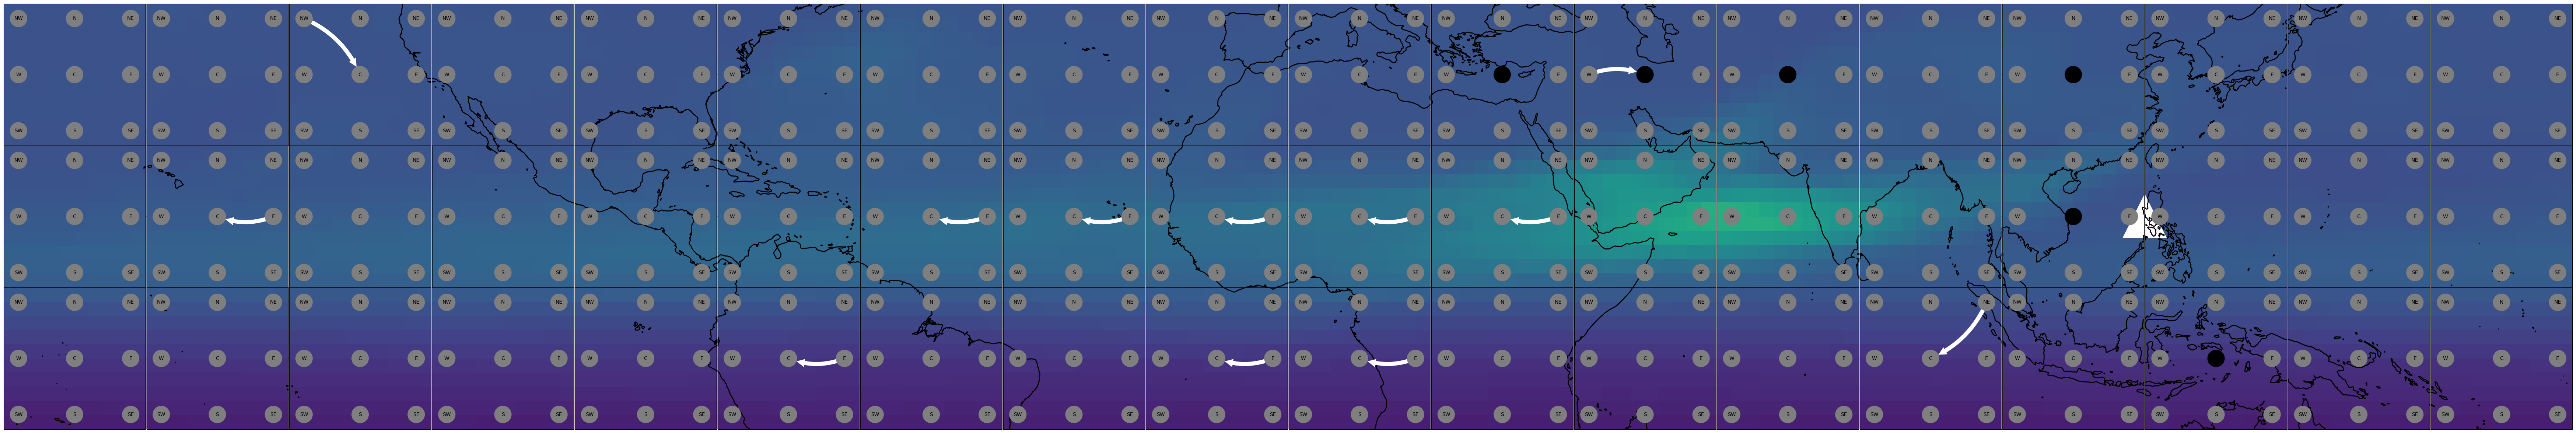

In [32]:
# Create a figure with a specified size based on the number of longitude and latitude bounds
fig = plt.figure(figsize=(len(lon_bounds) * 5, len(lat_bounds) * 5))
verbose = True

# Index for subplot positioning
idx = 1

# Loop through latitude and longitude bounds
for i, lat_bound in enumerate(lat_bounds):
    for j, lon_bound in enumerate(lon_bounds):
        if verbose:
            clear_output(wait=True)
            print(f"Computing on Latitudes: {lat_bound}")
            print(f"Computing on Longitudes: {lon_bound}")

        # Clip the data to the specified latitude and longitude bounds
        lat_lon_clipper = clif.preprocessing.ClipTransform(dims=["lat", "lon"], bounds=[lat_bound, lon_bound])
        space_clipped_data = lat_lon_clipper.fit_transform(ds["SULFATE"])

        # Extract the time-clipped data and transpose it to match the expected input format
        time_clipped_data = space_clipped_data.values[start_index:stop_index, :, :]
        data = np.transpose(time_clipped_data, (1, 2, 0))

        # Compute the causal graph and value matrix
        graph, v_matrix = sf.CaStLe_PC(
            data=data, cond_ind_test=parcorr, pc_alpha=pc_alpha, rows_inverted=False, dependence_threshold=castle_corr_threshold, dependencies_wrap=False
        )

        # Create subplots for the heatmap and stencil
        ax = fig.add_subplot(len(lat_bounds), len(lon_bounds), idx, projection=ccrs.PlateCarree())
        stencil_ax = fig.add_subplot(len(lat_bounds), len(lon_bounds), idx, projection=ccrs.PlateCarree())

        # Plot the heatmap with stencil
        stencil_plotting.plot_heatmap_with_stencil(
            fig_ax=(fig, ax),
            stencil_ax=stencil_ax,
            data_da=ds["SULFATE"],
            lat_bounds=lat_bound,
            lon_bounds=lon_bound,
            vmin=vmin,
            vmax=vmax,
            mark_source=True,
            source_coords=pinatubo_coords,
            graph=graph,
            v_matrix=v_matrix,
        )

        # Increment the subplot index
        idx += 1

# Adjust the layout to remove space between subplots
fig.subplots_adjust(wspace=0.0, hspace=0.0)

#### Enhancing Readability of Plots
Now that we have created the basic plots, let's enhance their readability by adding annotations and labels. This code adds the following:
1. Annotate the latitude and longitude lines for better readability.
2. Add gridlines with specified intervals to make the plots more understandable.
3. Add a colorbar below all the subplots to provide a reference for the sulfate concentration values.
4. Add a title with the start and end dates to give context to the plots.

Computing on Latitudes: (-15, 5)
Computing on Longitudes: (160, 180)


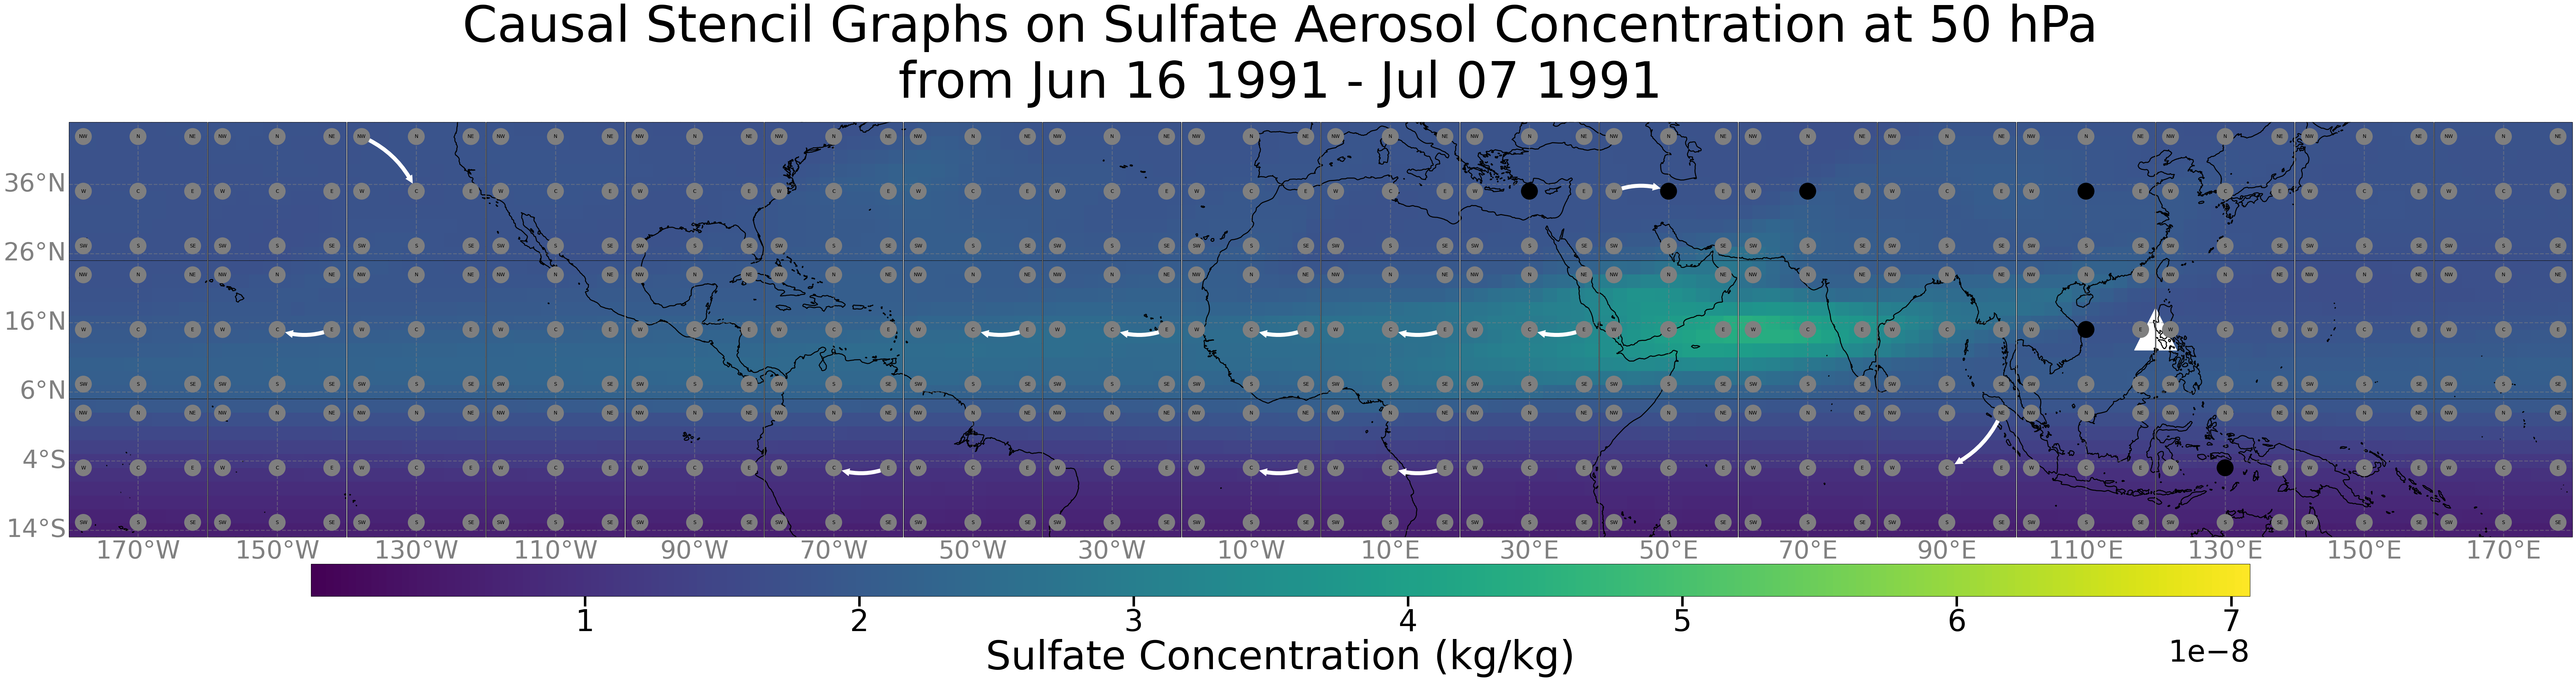

In [33]:
# Create a figure with a specified size based on the number of longitude and latitude bounds
fig = plt.figure(figsize=(len(lon_bounds) * 5, len(lat_bounds) * 5))
verbose = True

# Index for subplot positioning
idx = 1

# Loop through latitude and longitude bounds
for i, lat_bound in enumerate(lat_bounds):
    for j, lon_bound in enumerate(lon_bounds):
        if verbose:
            clear_output(wait=True)
            print(f"Computing on Latitudes: {lat_bound}")
            print(f"Computing on Longitudes: {lon_bound}")

        # Clip the data to the specified latitude and longitude bounds
        lat_lon_clipper = clif.preprocessing.ClipTransform(dims=["lat", "lon"], bounds=[lat_bound, lon_bound])
        space_clipped_data = lat_lon_clipper.fit_transform(ds["SULFATE"])

        # Extract the time-clipped data and transpose it to match the expected input format
        time_clipped_data = space_clipped_data.values[start_index:stop_index, :, :]
        data = np.transpose(time_clipped_data, (1, 2, 0))

        # Compute the causal graph and value matrix
        graph, v_matrix = sf.CaStLe_PC(
            data=data, cond_ind_test=parcorr, pc_alpha=pc_alpha, rows_inverted=False, dependence_threshold=castle_corr_threshold, dependencies_wrap=False
        )

        # Create subplots for the heatmap and stencil
        ax = fig.add_subplot(len(lat_bounds), len(lon_bounds), idx, projection=ccrs.PlateCarree())
        stencil_ax = fig.add_subplot(len(lat_bounds), len(lon_bounds), idx, projection=ccrs.PlateCarree())

        # Determine which labels to show
        show_left_labels = j == 0
        show_bottom_labels = i == len(lat_bounds) - 1
        show_lon_labels = show_bottom_labels
        show_lat_labels = show_left_labels

        # Plot the heatmap with stencil, adding annotations and gridlines for better readability
        stencil_plotting.plot_heatmap_with_stencil(
            fig_ax=(fig, ax),
            stencil_ax=stencil_ax,
            data_da=ds["SULFATE"],
            lat_bounds=lat_bound,
            lon_bounds=lon_bound,
            vmin=vmin,
            vmax=vmax,
            mark_source=True,
            source_coords=pinatubo_coords,
            graph=graph,
            v_matrix=v_matrix,
            annotate_lat_lon=True,  # Annotate latitude and longitude for better readability
            annotation_size=50,  # Set the size of the annotations
            gridline_interval=(10, 10),  # Set the interval for gridlines
            show_lat_labels=show_lat_labels,  # Show latitude labels on the left
            show_lon_labels=show_lon_labels,  # Show longitude labels on the bottom
        )

        # Increment the subplot index
        idx += 1

# Add a colorbar below all the subplots for better readability
cbar_ax = fig.add_axes([0.2, 0.00, 0.6, 0.06])  # [left, bottom, width, height]
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")
cbar.set_label(f"Sulfate Concentration ({ds['SULFATE'].units})", fontsize=80)
cbar.ax.tick_params(labelsize=60, width=5, length=20)
cbar.ax.xaxis.get_offset_text().set_size(60)
cbar.ax.yaxis.get_offset_text().set_size(60)

# Add a title with the start and end dates for better context
start_date = pd.Timestamp(ds.time.values[start_index])
end_date = pd.Timestamp(ds.time.values[stop_index])
start_date_formatted = start_date.strftime("%b %d %Y")
end_date_formatted = end_date.strftime("%b %d %Y")
plt.suptitle(f"Causal Stencil Graphs on Sulfate Aerosol Concentration at 50 hPa\nfrom {start_date_formatted} - {end_date_formatted}", fontsize=100, y=1.10)

# Adjust the layout to remove space between subplots
fig.subplots_adjust(wspace=0.0, hspace=0.0)

### Alternative region sizes
CaStLe results are generally robust to different subregion sizes, provided that dynamics are consistent in overlapping areas.

Computing on Latitudes: (-15, 15)
Computing on Longitudes: (150, 180)


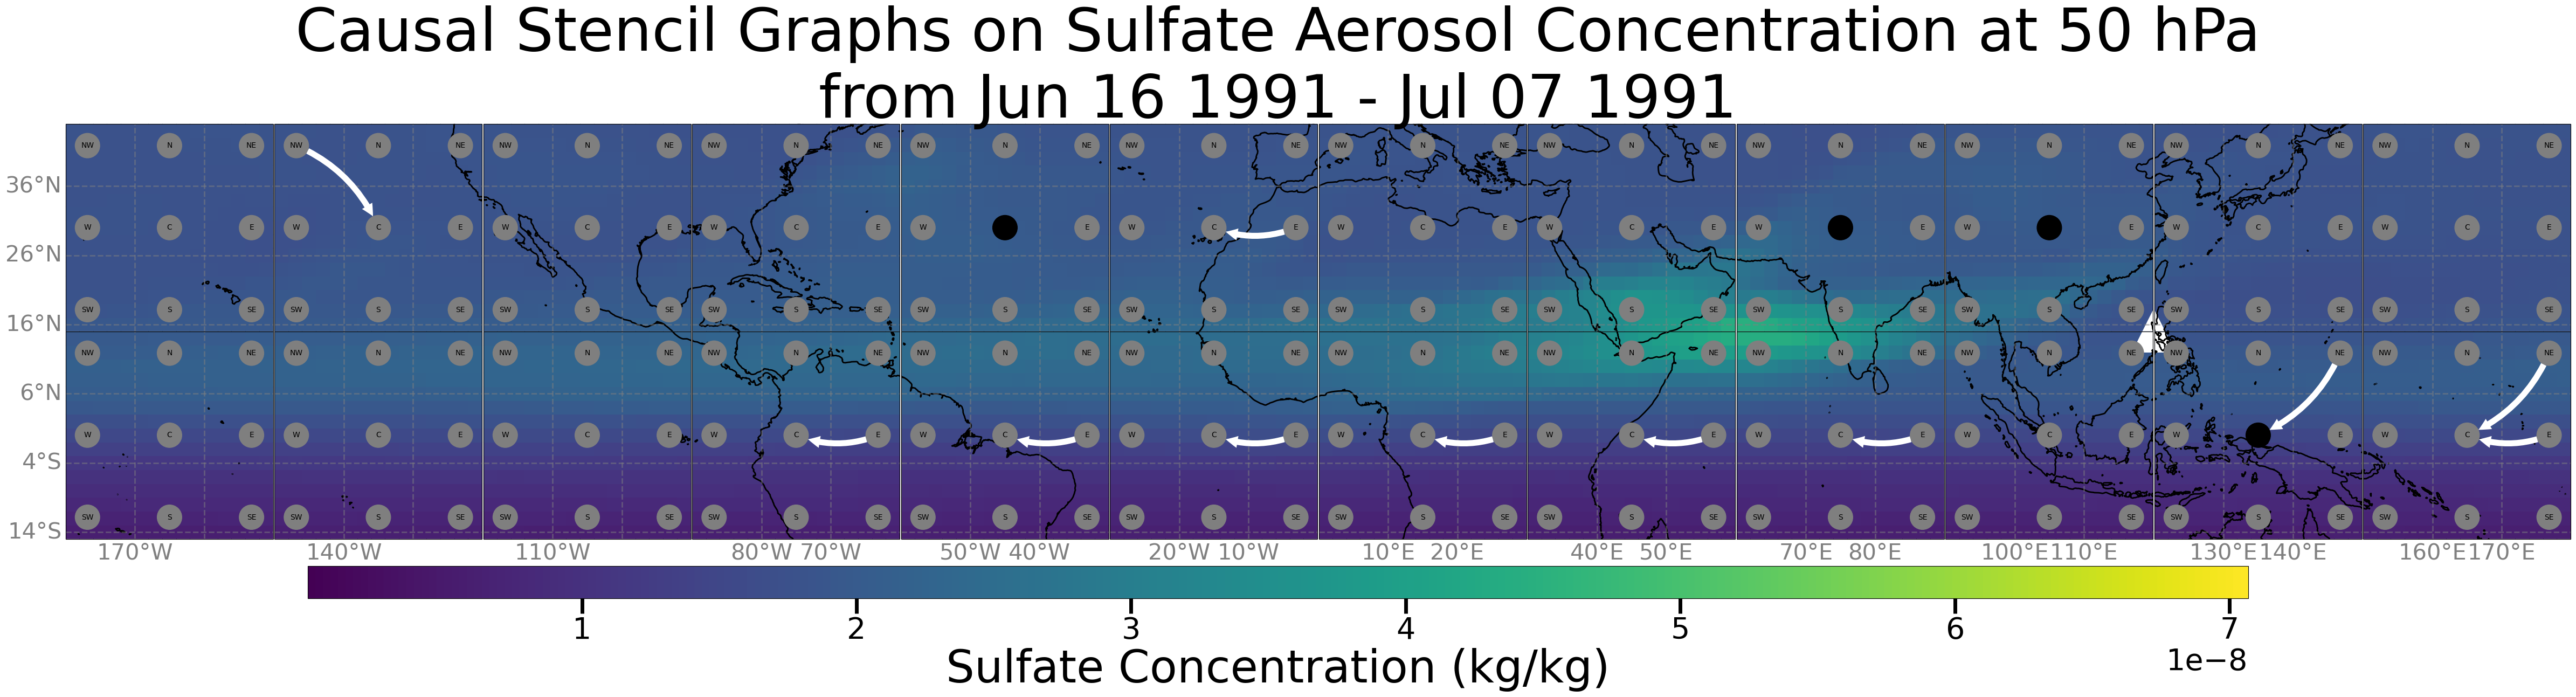

In [39]:
lat_bounds, lon_bounds = stencil_plotting.compute_bounds(region_size=30, lat_min=-15, lat_max=45, lon_min=-180, lon_max=180)

# Parameters
pinatubo_coords = (15, 120)
pc_alpha = 0.01
castle_corr_threshold = 0.0

# Calculate spatial mean and value range
lat_lon_clipper = clif.preprocessing.ClipTransform(dims=["lat", "lon"], bounds=[(lat_min, lat_max), (lon_min, lon_max)])
space_clipped_data = lat_lon_clipper.fit_transform(ds["SULFATE"])
spatial_ts_mean = np.mean(space_clipped_data, axis=(1, 2))[start_index:stop_index].values
vmin, vmax = spatial_ts_mean.min(), spatial_ts_mean.max()

# Create a figure with a specified size based on the number of longitude and latitude bounds
fig = plt.figure(figsize=(len(lon_bounds) * 5, len(lat_bounds) * 5))
verbose = True

# Index for subplot positioning
idx = 1

# Loop through latitude and longitude bounds
for i, lat_bound in enumerate(lat_bounds):
    for j, lon_bound in enumerate(lon_bounds):
        if verbose:
            clear_output(wait=True)
            print(f"Computing on Latitudes: {lat_bound}")
            print(f"Computing on Longitudes: {lon_bound}")

        # Clip the data to the specified latitude and longitude bounds
        lat_lon_clipper = clif.preprocessing.ClipTransform(dims=["lat", "lon"], bounds=[lat_bound, lon_bound])
        space_clipped_data = lat_lon_clipper.fit_transform(ds["SULFATE"])

        # Extract the time-clipped data and transpose it to match the expected input format
        time_clipped_data = space_clipped_data.values[start_index:stop_index, :, :]
        data = np.transpose(time_clipped_data, (1, 2, 0))

        # Compute the causal graph and value matrix
        graph, v_matrix = sf.CaStLe_PC(
            data=data, cond_ind_test=parcorr, pc_alpha=pc_alpha, rows_inverted=False, dependence_threshold=castle_corr_threshold, dependencies_wrap=False
        )

        # Create subplots for the heatmap and stencil
        ax = fig.add_subplot(len(lat_bounds), len(lon_bounds), idx, projection=ccrs.PlateCarree())
        stencil_ax = fig.add_subplot(len(lat_bounds), len(lon_bounds), idx, projection=ccrs.PlateCarree())

        # Determine which labels to show
        show_left_labels = j == 0
        show_bottom_labels = i == len(lat_bounds) - 1
        show_lon_labels = show_bottom_labels
        show_lat_labels = show_left_labels

        # Plot the heatmap with stencil, adding annotations and gridlines for better readability
        stencil_plotting.plot_heatmap_with_stencil(
            fig_ax=(fig, ax),
            stencil_ax=stencil_ax,
            data_da=ds["SULFATE"],
            lat_bounds=lat_bound,
            lon_bounds=lon_bound,
            vmin=vmin,
            vmax=vmax,
            mark_source=True,
            source_coords=pinatubo_coords,
            graph=graph,
            v_matrix=v_matrix,
            annotate_lat_lon=True,  # Annotate latitude and longitude for better readability
            annotation_size=30,  # Set the size of the annotations
            gridline_interval=(10, 10),  # Set the interval for gridlines
            show_lat_labels=show_lat_labels,  # Show latitude labels on the left
            show_lon_labels=show_lon_labels,  # Show longitude labels on the bottom
        )

        # Increment the subplot index
        idx += 1

# Add a colorbar below all the subplots for better readability
cbar_ax = fig.add_axes([0.2, 0.00, 0.6, 0.06])  # [left, bottom, width, height]
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")
cbar.set_label(f"Sulfate Concentration ({ds['SULFATE'].units})", fontsize=60)
cbar.ax.tick_params(labelsize=40, width=5, length=20)
cbar.ax.xaxis.get_offset_text().set_size(40)
cbar.ax.yaxis.get_offset_text().set_size(40)

# Add a title with the start and end dates for better context
start_date = pd.Timestamp(ds.time.values[start_index])
end_date = pd.Timestamp(ds.time.values[stop_index])
start_date_formatted = start_date.strftime("%b %d %Y")
end_date_formatted = end_date.strftime("%b %d %Y")
plt.suptitle(f"Causal Stencil Graphs on Sulfate Aerosol Concentration at 50 hPa\nfrom {start_date_formatted} - {end_date_formatted}", fontsize=80, y=1.10)

# Adjust the layout to remove space between subplots
fig.subplots_adjust(wspace=0.0, hspace=0.0)

Computing on Latitudes: (-15, 45)
Computing on Longitudes: (120, 180)


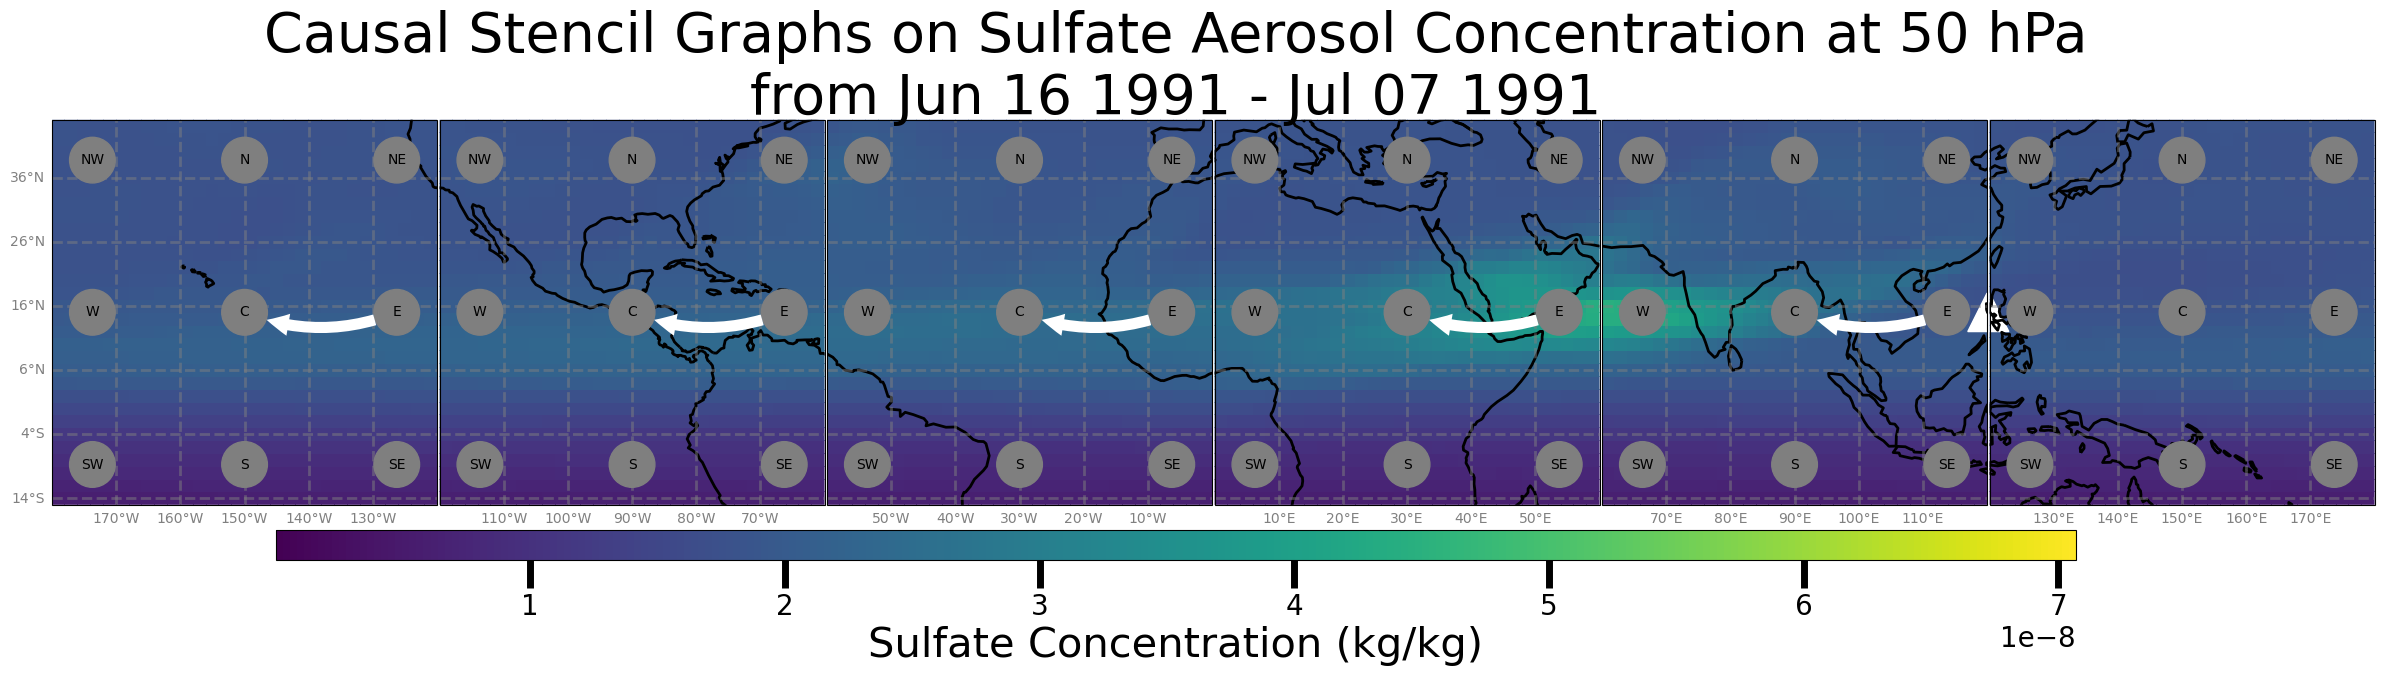

In [43]:
lat_bounds, lon_bounds = stencil_plotting.compute_bounds(region_size=60, lat_min=-15, lat_max=45, lon_min=-180, lon_max=180)

# Parameters
pinatubo_coords = (15, 120)
pc_alpha = 0.01
castle_corr_threshold = 0.0

# Calculate spatial mean and value range
lat_lon_clipper = clif.preprocessing.ClipTransform(dims=["lat", "lon"], bounds=[(lat_min, lat_max), (lon_min, lon_max)])
space_clipped_data = lat_lon_clipper.fit_transform(ds["SULFATE"])
spatial_ts_mean = np.mean(space_clipped_data, axis=(1, 2))[start_index:stop_index].values
vmin, vmax = spatial_ts_mean.min(), spatial_ts_mean.max()

# Create a figure with a specified size based on the number of longitude and latitude bounds
fig = plt.figure(figsize=(len(lon_bounds) * 5, len(lat_bounds) * 5))
verbose = True

# Index for subplot positioning
idx = 1

# Loop through latitude and longitude bounds
for i, lat_bound in enumerate(lat_bounds):
    for j, lon_bound in enumerate(lon_bounds):
        if verbose:
            clear_output(wait=True)
            print(f"Computing on Latitudes: {lat_bound}")
            print(f"Computing on Longitudes: {lon_bound}")

        # Clip the data to the specified latitude and longitude bounds
        lat_lon_clipper = clif.preprocessing.ClipTransform(dims=["lat", "lon"], bounds=[lat_bound, lon_bound])
        space_clipped_data = lat_lon_clipper.fit_transform(ds["SULFATE"])

        # Extract the time-clipped data and transpose it to match the expected input format
        time_clipped_data = space_clipped_data.values[start_index:stop_index, :, :]
        data = np.transpose(time_clipped_data, (1, 2, 0))

        # Compute the causal graph and value matrix
        graph, v_matrix = sf.CaStLe_PC(
            data=data, cond_ind_test=parcorr, pc_alpha=pc_alpha, rows_inverted=False, dependence_threshold=castle_corr_threshold, dependencies_wrap=False
        )

        # Create subplots for the heatmap and stencil
        ax = fig.add_subplot(len(lat_bounds), len(lon_bounds), idx, projection=ccrs.PlateCarree())
        stencil_ax = fig.add_subplot(len(lat_bounds), len(lon_bounds), idx, projection=ccrs.PlateCarree())

        # Determine which labels to show
        show_left_labels = j == 0
        show_bottom_labels = i == len(lat_bounds) - 1
        show_lon_labels = show_bottom_labels
        show_lat_labels = show_left_labels

        # Plot the heatmap with stencil, adding annotations and gridlines for better readability
        stencil_plotting.plot_heatmap_with_stencil(
            fig_ax=(fig, ax),
            stencil_ax=stencil_ax,
            data_da=ds["SULFATE"],
            lat_bounds=lat_bound,
            lon_bounds=lon_bound,
            vmin=vmin,
            vmax=vmax,
            mark_source=True,
            source_coords=pinatubo_coords,
            graph=graph,
            v_matrix=v_matrix,
            annotate_lat_lon=True,  # Annotate latitude and longitude for better readability
            annotation_size=10,  # Set the size of the annotations
            gridline_interval=(10, 10),  # Set the interval for gridlines
            show_lat_labels=show_lat_labels,  # Show latitude labels on the left
            show_lon_labels=show_lon_labels,  # Show longitude labels on the bottom
        )

        # Increment the subplot index
        idx += 1

# Add a colorbar below all the subplots for better readability
cbar_ax = fig.add_axes([0.2, 0.00, 0.6, 0.06])  # [left, bottom, width, height]
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")
cbar.set_label(f"Sulfate Concentration ({ds['SULFATE'].units})", fontsize=30)
cbar.ax.tick_params(labelsize=20, width=5, length=20)
cbar.ax.xaxis.get_offset_text().set_size(20)
cbar.ax.yaxis.get_offset_text().set_size(20)

# Add a title with the start and end dates for better context
start_date = pd.Timestamp(ds.time.values[start_index])
end_date = pd.Timestamp(ds.time.values[stop_index])
start_date_formatted = start_date.strftime("%b %d %Y")
end_date_formatted = end_date.strftime("%b %d %Y")
plt.suptitle(f"Causal Stencil Graphs on Sulfate Aerosol Concentration at 50 hPa\nfrom {start_date_formatted} - {end_date_formatted}", fontsize=40, y=1.10)

# Adjust the layout to remove space between subplots
fig.subplots_adjust(wspace=0.0, hspace=0.0)

## CaStLe on Aerosol Optical Depth (AOD)
We also have AOD data from the same simulation run available for demonstration. Since this simple model only includes aerosols from the Mt. Pinatubo eruption, AOD comprises sulfates from all atmosphere levels. These provide a similar analysis but with some different nuances.

In [60]:
file_path = "../data/AOD.nc"
ds_aod = xr.open_dataset(file_path)
# Remake longitude coords to be -180 to 180 instead of 0 to 360
ds_aod.coords["lon"] = (ds_aod.coords["lon"] + 180) % 360 - 180
ds_aod = ds_aod.sortby(ds_aod.lon)

lat_min = -15  # -20
lat_max = 45  # 50
lon_min = -180
lon_max = 180
lat_lon_clipper = clif.preprocessing.ClipTransform(dims=["lat", "lon"], bounds=[(lat_min, lat_max + 1), (lon_min, lon_max + 1)])

da_aod = lat_lon_clipper.fit_transform(ds_aod["AOD"])

start_index = 366  # Its best to start a little after the eruption day (361) to make sure the signal has started propagating.
stop_index = 450
max_stop_index = stop_index

aod_spatial_TS_total = np.mean(da_aod, axis=(1, 2))[start_index:max_stop_index].values
vmin = aod_spatial_TS_total.min()
vmax = aod_spatial_TS_total.max()

aod_arr = da_aod.values[start_index:stop_index, :, :]
aod_arr = np.transpose(aod_arr, (1, 2, 0))

lon_bound = (lon_min, lon_max)
lat_bound = (lat_min, lat_max)
lats = da_aod["lat"]
lons = da_aod["lon"]
lons, lats = np.meshgrid(lons, lats)

CaStLe with PCMCI or DYNOTEARS seems to work best for this species. We'll demonstrate with DYNOTEARS below.

Computing on Latitudes: (-15, 15)
Computing on Longitudes: (150, 180)


/Users/jefnich/.local/lib/python3.10/site-packages/causalnex/structure/transformers.py:198: FutureWarning: RangeIndex.is_integer is deprecated. Use pandas.api.types.is_integer_dtype instead.
  if not t.index.is_integer():
/Users/jefnich/.local/lib/python3.10/site-packages/causalnex/structure/transformers.py:198: FutureWarning: RangeIndex.is_integer is deprecated. Use pandas.api.types.is_integer_dtype instead.
  if not t.index.is_integer():


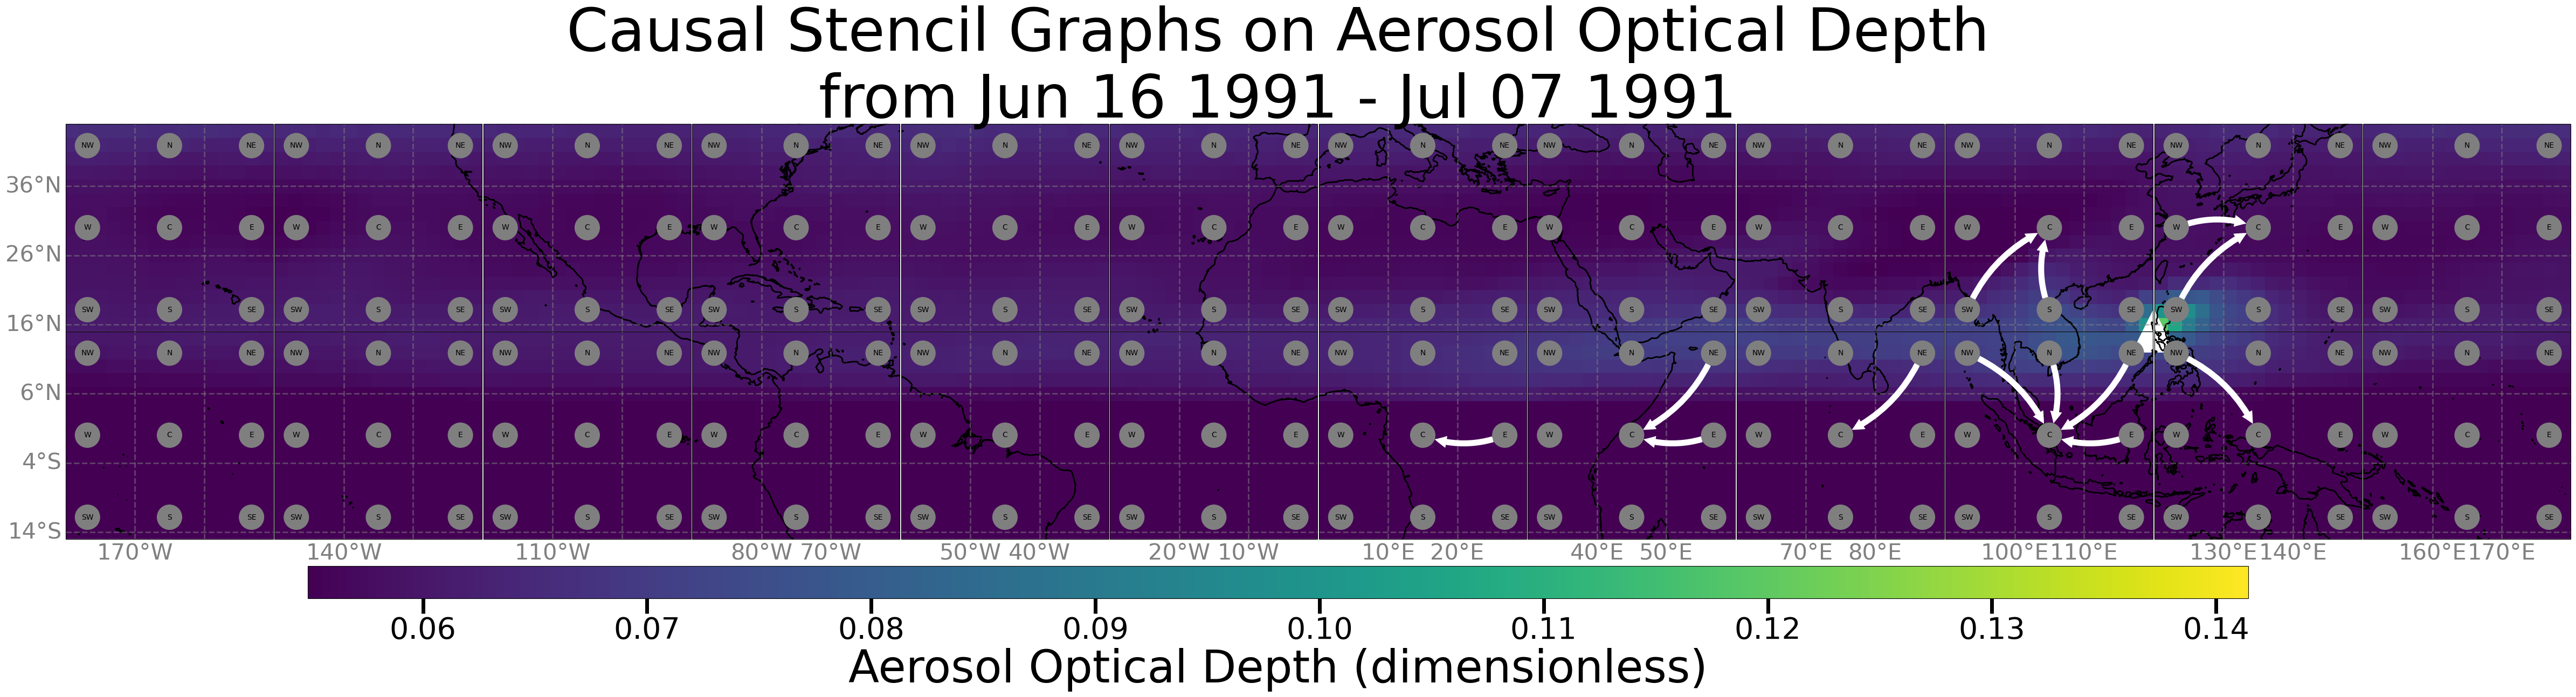

In [68]:
# pc_alpha = 0.01
castle_corr_threshold = 0.0

lat_bounds, lon_bounds = stencil_plotting.compute_bounds(region_size=30, lat_min=-15, lat_max=45, lon_min=-180, lon_max=180)

# Parameters
pinatubo_coords = (15, 120)
pc_alpha = 0.01
castle_corr_threshold = 0.0

# Create a figure with a specified size based on the number of longitude and latitude bounds
fig = plt.figure(figsize=(len(lon_bounds) * 5, len(lat_bounds) * 5))
verbose = True

# Index for subplot positioning
idx = 1

# Loop through latitude and longitude bounds
for i, lat_bound in enumerate(lat_bounds):
    for j, lon_bound in enumerate(lon_bounds):
        if verbose:
            clear_output(wait=True)
            print(f"Computing on Latitudes: {lat_bound}")
            print(f"Computing on Longitudes: {lon_bound}")

        # Clip the data to the specified latitude and longitude bounds
        lat_lon_clipper = clif.preprocessing.ClipTransform(dims=["lat", "lon"], bounds=[lat_bound, lon_bound])
        space_clipped_data = lat_lon_clipper.fit_transform(ds_aod["AOD"])

        # Extract the time-clipped data and transpose it to match the expected input format
        time_clipped_data = space_clipped_data.values[start_index:stop_index, :, :]
        data = np.transpose(time_clipped_data, (1, 2, 0))

        # Compute the causal graph and value matrix
        # graph, v_matrix = sf.CaStLe_PCMCI(
        #     data=data, cond_ind_test=parcorr, pc_alpha=pc_alpha, rows_inverted=False, dependence_threshold=castle_corr_threshold, dependencies_wrap=False
        # )
        graph, v_matrix = sf.CaStLe_DYNOTEARS(data=data, dependence_threshold=castle_corr_threshold)

        # Create subplots for the heatmap and stencil
        ax = fig.add_subplot(len(lat_bounds), len(lon_bounds), idx, projection=ccrs.PlateCarree())
        stencil_ax = fig.add_subplot(len(lat_bounds), len(lon_bounds), idx, projection=ccrs.PlateCarree())

        # Determine which labels to show
        show_left_labels = j == 0
        show_bottom_labels = i == len(lat_bounds) - 1
        show_lon_labels = show_bottom_labels
        show_lat_labels = show_left_labels

        # Plot the heatmap with stencil, adding annotations and gridlines for better readability
        stencil_plotting.plot_heatmap_with_stencil(
            fig_ax=(fig, ax),
            stencil_ax=stencil_ax,
            data_da=ds_aod["AOD"],
            lat_bounds=lat_bound,
            lon_bounds=lon_bound,
            vmin=vmin,
            vmax=vmax,
            mark_source=True,
            source_coords=pinatubo_coords,
            graph=graph,
            v_matrix=v_matrix,
            annotate_lat_lon=True,  # Annotate latitude and longitude for better readability
            annotation_size=30,  # Set the size of the annotations
            gridline_interval=(10, 10),  # Set the interval for gridlines
            show_lat_labels=show_lat_labels,  # Show latitude labels on the left
            show_lon_labels=show_lon_labels,  # Show longitude labels on the bottom
        )

        # Increment the subplot index
        idx += 1

# Add a colorbar below all the subplots for better readability
cbar_ax = fig.add_axes([0.2, 0.00, 0.6, 0.06])  # [left, bottom, width, height]
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")
cbar.set_label(f"Aerosol Optical Depth ({ds_aod['AOD'].units})", fontsize=60)
cbar.ax.tick_params(labelsize=40, width=5, length=20)
cbar.ax.xaxis.get_offset_text().set_size(40)
cbar.ax.yaxis.get_offset_text().set_size(40)

# Add a title with the start and end dates for better context
start_date = pd.Timestamp(ds.time.values[start_index])
end_date = pd.Timestamp(ds.time.values[stop_index])
start_date_formatted = start_date.strftime("%b %d %Y")
end_date_formatted = end_date.strftime("%b %d %Y")
plt.suptitle(f"Causal Stencil Graphs on Aerosol Optical Depth\nfrom {start_date_formatted} - {end_date_formatted}", fontsize=80, y=1.10)

# Adjust the layout to remove space between subplots
fig.subplots_adjust(wspace=0.0, hspace=0.0)

 We see that, in this case, CaStLe captures the plume dispersal from the epicenter in many directions before the primary westward advection.